---
# 1. Paramètrage environnement

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping

In [2]:
def plot_result_fitting(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Evolution de la précision')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Evolution de la fonction de perte')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_retention_map.png',
                transparent=True)
    
    return None

---
# 2. Préparation des données
## 2-1. Création du dataframe

Pour commencer, je récupère les données sous forme de dataframe afin de faciliter la découpe des fichier d'entraînement, de validation et de test.

In [3]:
dogs_lst = []
for dirname, _, filenames in os.walk('../input/stanford-dogs-dataset/images'):
    for filename in filenames:
        dogs_lst.append(os.path.join(dirname, filename))

# Je stocke dans un dataframe
dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

# J'extrais la race
dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)

dogs = dogs_raw

dogs

,uri,breeds
0,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
1,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
2,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
3,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
4,../input/stanford-dogs-dataset/images/Images/n...,Lakeland_terrier
...,...,...
20575,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle
20576,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle
20577,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle
20578,../input/stanford-dogs-dataset/images/Images/n...,miniature_poodle


In [4]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

# Séparation des données d'entrainements et de validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [5]:
### Paramétrage
target_size = (256, 256) # default
#target_size = (150, 150)
batch_size = 32 # default
# batch_size = 16

## 2-2. Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True)

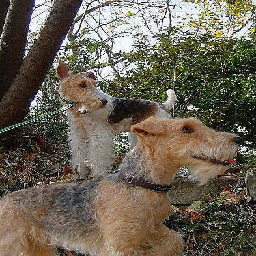

In [7]:
img = image.load_img(dogs_raw.uri[5], target_size=target_size)
img

In [8]:
def get_img_aug(img, datagen):
    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    
    i = 0 
    y = 0
    z = 0
    for batch in datagen.flow(x):
        ax[y, z].imshow(image.array_to_img(batch[0])) 
        ax[y, z].set_title('Augmentation ' + str(i))
        # Changement de subplot
        z += 1
        if z % 2 == 0 : 
            z=0
            y=1

        # Arrêt au bout de 4 images
        i+=1
        if i % 4 == 0 :
            plt.savefig('./cnn_augmentation.png', transparent=True)
            break

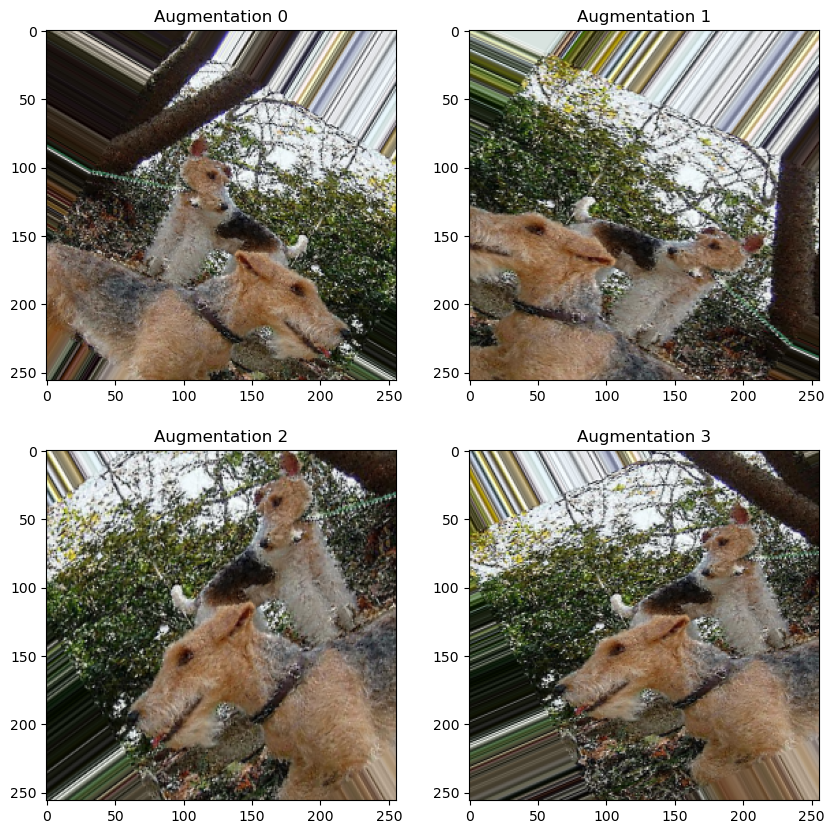

In [9]:
get_img_aug(img, train_datagen)

Grâce à l'augmentation des données, l'algorithme ne verra qu'une fois la même image. Cela aura pour effet de limiter le surapprentisage.

## 2-3. Création des générateurs

In [10]:
train_gen = train_datagen.flow_from_dataframe(
                  train,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=batch_size,
                  seed=42
                  )

# Génération des données de validation et de test
val_test_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=batch_size,
                  seed=42
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=batch_size,
                  seed=42
                  )

Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.


# 3. CNN from scratch
## 3-1. Création du modèle

In [11]:
model = Sequential()

### Couches de convolutions
# Couche 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))

# Couche 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Couche 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Couche 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))


model.add(Dropout(0.5))
### Couches de classification
# Applatissement (transform to vector 1D)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(train_gen.class_indices), activation='softmax'))

# Résumé du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

## 3-2. Entrainement du modèle

Epoch 1/500
412/412 [==============================] - 287s 698ms/step - loss: 4.7866 - accuracy: 0.0108 - val_loss: 4.7842 - val_accuracy: 0.0137
Epoch 2/500
412/412 [==============================] - 258s 627ms/step - loss: 4.7824 - accuracy: 0.0115 - val_loss: 4.7835 - val_accuracy: 0.0137
Epoch 3/500
412/412 [==============================] - 260s 630ms/step - loss: 4.7807 - accuracy: 0.0112 - val_loss: 4.7832 - val_accuracy: 0.0137
Epoch 4/500
412/412 [==============================] - 262s 636ms/step - loss: 4.7797 - accuracy: 0.0121 - val_loss: 4.7825 - val_accuracy: 0.0128
Epoch 5/500
412/412 [==============================] - 255s 619ms/step - loss: 4.7737 - accuracy: 0.0129 - val_loss: 4.7900 - val_accuracy: 0.0140
Epoch 6/500
412/412 [==============================] - 262s 636ms/step - loss: 4.7648 - accuracy: 0.0144 - val_loss: 4.7689 - val_accuracy: 0.0173
Epoch 7/500
412/412 [==============================] - 253s 615ms/step - loss: 4.7558 - accuracy: 0.0154 - val_loss: 4

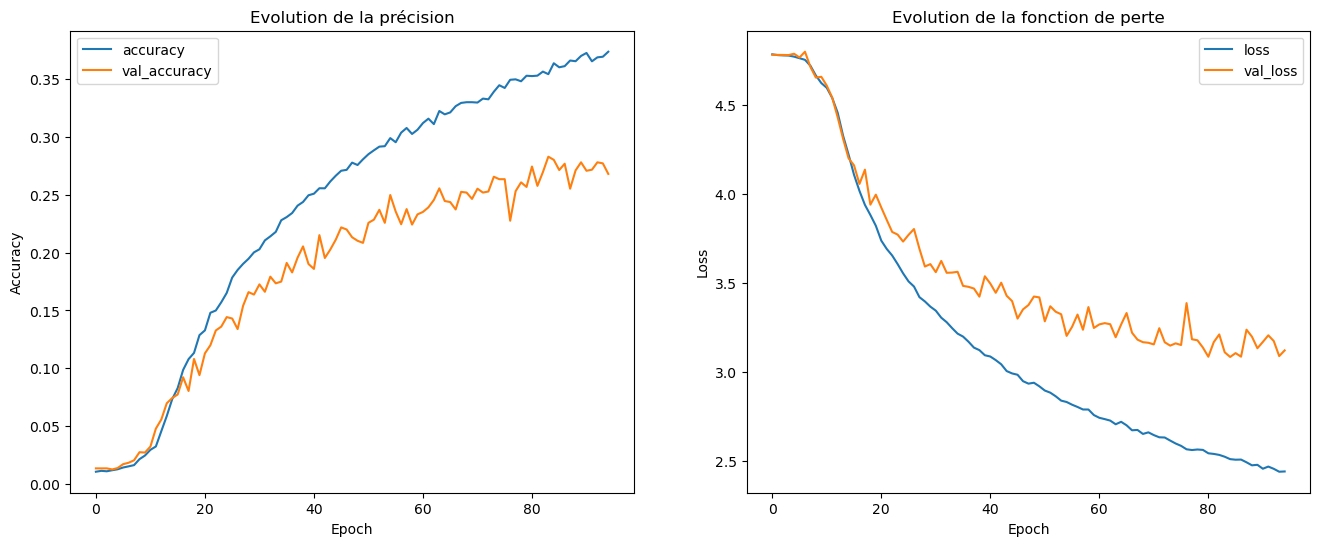

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)

history = model.fit(train_gen, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor])

plot_result_fitting(history)

Malgré un surapprentissage, le modèle présente des courbes stables.

## 3-3. Evaluation du modèle sur les données de test

In [13]:
model.evaluate(test_gen)

129/129 [==============================] - 29s 226ms/step - loss: 3.0671 - accuracy: 0.2787


[3.067131757736206, 0.278668612241745]

Le modèle présente un resultat de presque 28 % sur des images qu'il n'a jamais rencontrées.